# Hippocampus

## Pattern separation

Define DG block. 

This layer transforms an input into a sparse tensor. Simple approach:

In [1]:
class DGModel(nn.Module):
    """
    Goal: separation
    Methods: sparsity
    """
    
    def __init__(self, input_size, output_size):
        super(DGModel, self).__init__()
        self.fc1 = nn.Linear(input_size, output_size)
        nn.init.xavier_uniform_(self.fc1.weight)
        
    def forward(self, x):
        with torch.no_grad():
            x = self.fc1(x)
            x = torch.tanh(x)
        return x

NameError: name 'nn' is not defined


But the result of this network is very noisy tensor with many cells active at the same time. 

How to keep the sparsity effect that even a small difference in input creates a different output? Also it should have very little of active cells (Maybe the same amount of active cells as in the input.)


Some inspiration about [highly sparse representation](https://arxiv.org/pdf/1903.11257) one can take from a work of Subutai Ahmad.

>  we initialize the weights using a sparse random distribution, 
> such that only a fraction of the weights contain non-zero values.
> Non-zero weights are initialized using standard Kaiming initialization 

- We compute the top $k$ highest activations using `torch.topk`. After applying `tanh` to ensure non-linearity, the top $k$ activations are kept. The rest of the activations are zeroed out.
- 

In [11]:
import random

import torch
import torch.nn as nn
import torch.optim as optim

class DGModel(nn.Module):
    """
    Goal: separation
    Methods: sparsity
    """
    
    def __init__(self, input_size, output_size):
        super(DGModel, self).__init__()
        hidden_layer_size = input_size + output_size // 2
        # self.fc1 = nn.Linear(input_size, hidden_layer_size)
        # self.fc2 = nn.Linear(hidden_layer_size, output_size)
        self.fc1 = nn.Linear(input_size, output_size)
        
        # we have an array from 0 to input_size * output_size - 1. 
        # We want only 20-50%% of these elements to be active
        # we need to pick randomly n = 0.2 * (input_size * output_size) unique numbers from this interval
        m = input_size * output_size
        n = int(0.05 * m)
        active_spots = random.sample(range(m), n)  # pick `n` unique numbers from [0, m)
        
        # Weight initialization (Xavier)
        nn.init.kaiming_normal_(self.fc1.weight)
        
        mask = torch.zeros_like(self.fc1.weight)
        mask.view(-1)[active_spots] = 1
        self.fc1.weight.data *= mask

        # nn.init.xavier_uniform_(self.fc2.weight)
        self.k = 5  # Number of top activations to keep
        self.prev_step_topk_pos_indices = None
        self.prev_step_topk_neg_indices = None
        
    def forward(self, x):
        with torch.no_grad():  # Ensure no gradients are calculated for this model
            x = self.fc1(x)
            x = torch.tanh(x)  # Using tanh activation
            # x = self.fc2(x)
            # x = torch.relu(x)
            
            # k winner
            mask_pos = torch.zeros_like(x)
            mask_neg = torch.zeros_like(x)
            _, topk_pos_indices = torch.topk(x, self.k, largest=True)
            _, topk_neg_indices = torch.topk(x, self.k, largest=False)
            
            # boosting
            if self.prev_step_topk_pos_indices:
                topk_pos_indices = [topk_pos_indices[i] for i in range(len(topk_pos_indices)) if i not in self.prev_step_topk_pos_indices]
            else:
                self.prev_step_topk_pos_indices = topk_pos_indices
                
            if self.prev_step_topk_neg_indices:
                topk_neg_indices = [topk_neg_indices[i] for i in range(len(topk_neg_indices)) if i not in self.prev_step_topk_neg_indices]
            else:
                self.prev_step_topk_neg_indices = topk_neg_indices
            mask_pos.scatter_(0, topk_pos_indices, 1)
            mask_neg.scatter_(0, topk_neg_indices, 1)
            
            x = x * (mask_pos + mask_neg)
        return x


### Homework

Add L1 Regularization.

Although more common in continuous domains, L1 regularization pushes activations toward zero, promoting sparsity.

PyTorch doesn’t provide a built-in L1 regularization option within the optimizers, so you must manually add the L1 penalty to the loss.

Here's a sketch

In [ ]:
lambda_l1 = 0.01  # Strength of L1 regularization

# Define a function for L1 regularization
def l1_regularization(model, lambda_l1):
    l1_penalty = 0
    for param in model.parameters():
        l1_penalty += torch.sum(torch.abs(param))
    return lambda_l1 * l1_penalty

sparse_output = model(original_input)
main_loss = criterion(sparse_output, target_output)
l1_loss = l1_regularization(model, lambda_l1)
total_loss = main_loss + l1_loss
total_loss.backward()
optimizer.step()

We need some data to test these blocks

In [2]:
import math

w = 5
h = 5
sk = 5
w_s = w * sk
h_s = h * sk

# dg_model - Sparse encoding
N = w * h  # Input size
M = w_s * h_s   # Output size

# ec_to_ca3_model - Correcting encoding
H = N  # Input size
L = M   # Output size ?? M ??

# ca3_memory_model
T = M # or L # Input size
K = T # Output size = Input size

# ca1_model
input_size = N + K # the original input pattern + memory
hidden_size = math.floor(input_size * 0.7)  # Size of hidden layer
output_size = N  # Same as input size for reconstruction

def to_uni_binary(t):
    """from [0, 1] to [-1, 1]"""
    return t * 2.0 - 1.0

# super simple ARC-like example
input_1 = torch.tensor([[0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0],
                          [0, 0, 1, 0, 0],
                          [0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0]], dtype=torch.float)

output_1 = torch.tensor([[0, 0, 1, 0, 0],
                           [0, 0, 1, 0, 0],
                           [1, 1, 1, 1, 1],
                           [0, 0, 1, 0, 0],
                           [0, 0, 1, 0, 0]], dtype=torch.float)

input_2 = torch.tensor([[0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 1]], dtype=torch.float)

output_2 = torch.tensor([[0, 0, 0, 0, 1],
                           [0, 0, 0, 0, 1],
                           [0, 0, 0, 0, 1],
                           [0, 0, 0, 0, 1],
                           [1, 1, 1, 1, 1]], dtype=torch.float)

We are going to work with 1D arrays. 

DG block creates a sparse representation of the input

In [12]:
dg_model = DGModel(N, M)

def forward_dg_model(dg_model, x):
    return dg_model(x.flatten())


In [5]:
x = input_1.flatten()
xx = input_2.flatten()

y = forward_dg_model(dg_model, x)
yy = forward_dg_model(dg_model, xx)

print(y)
print(y.shape)

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

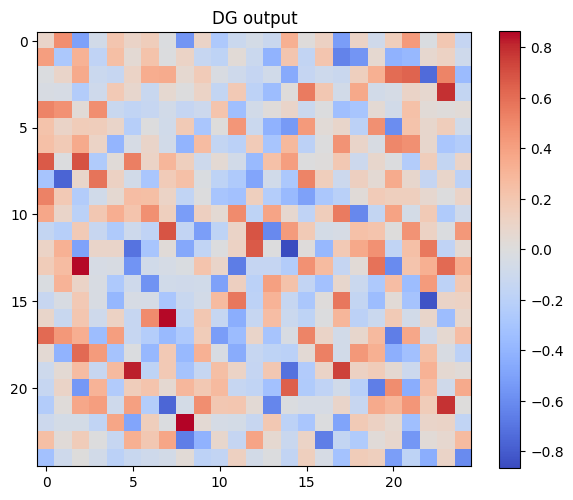

In [14]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

temp = torch.tanh(dg_model.fc1(x))
plt.figure(figsize=(6, 5))
w_mat = plt.imshow(temp.view(25, 25).detach().numpy(), cmap=cm.coolwarm)
plt.colorbar(w_mat)
plt.title("DG output")
plt.tight_layout()
plt.show()
# temp

In [335]:
torch.topk(x, 5, largest=True)

torch.return_types.topk(
values=tensor([ 1., -1., -1., -1., -1.]),
indices=tensor([12,  0,  1,  2,  3]))

In [336]:
torch.topk(x, 5, largest=False)

torch.return_types.topk(
values=tensor([-1., -1., -1., -1., -1.]),
indices=tensor([0, 1, 2, 3, 4]))

Before the sparse representation hits the memory
we need to add one independent network between the same input and the memory in parallel.
This will be used later as part of retrieval.
Its goal would be to help balance between sparse representation and real input and select important regions 
(that would help with ignoring noise (or with detecting invariants))

We add an Encoding model

In [ ]:
class EncodingModel(nn.Module):
    """
    Goal: pattern retrieval
    Methods: compare sparse representation with the original
    """
    
    def __init__(self, input_size, output_size):
        super(EncodingModel, self).__init__()
        hidden_layer_size = output_size
        self.fc1 = nn.Linear(input_size, hidden_layer_size)
        self.fc2 = nn.Linear(hidden_layer_size, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = torch.tanh(x)
        x = self.fc2(x)
        # x = torch.clamp(x * 10.0, min=-1.0, max=1.0)
        return x

In [ ]:
ec_model = EncodingModel(H, L)
ec_optimizer = optim.AdamW(ec_model.parameters(), lr=0.0001)
ec_criterion = nn.MSELoss() # good for comparing pixel values

def forward_ec_to_ca3_model(ec_model, x):
    return ec_model(x)

def train_ec_to_ca3_model(ec_model, x, y):
    # Zero the parameter gradients
    ec_optimizer.zero_grad()

    # Compare reconstruction with the original input
    
    z = forward_ec_to_ca3_model(ec_model, x)
    loss = ec_criterion(z, y)

    # Backward pass: compute gradients
    loss.backward()

    # Optimization step: update weights
    ec_optimizer.step()

    print("Loss:", loss.item())
    # print("EC -> CA3 output:", z)
    
    return z, loss.item()


In [ ]:
for i in range(500):
    print(i, "train_ec_to_ca3")
    z, loss1 = train_ec_to_ca3_model(ec_model, x, y)
    zz, loss2 = train_ec_to_ca3_model(ec_model, xx, yy)
    loss = (loss1 + loss2) / 2.0
    if loss < 0.0001:
        break

0 train_ec_to_ca3
Loss: 0.09437482804059982
Loss: 0.08751139789819717
1 train_ec_to_ca3
Loss: 0.07361914962530136
Loss: 0.06922343373298645
2 train_ec_to_ca3
Loss: 0.058131348341703415
Loss: 0.05448833480477333
3 train_ec_to_ca3
Loss: 0.04619700461626053
Loss: 0.04303606227040291
4 train_ec_to_ca3
Loss: 0.03712138533592224
Loss: 0.0343376025557518
5 train_ec_to_ca3
Loss: 0.03029252029955387
Loss: 0.027809053659439087
6 train_ec_to_ca3
Loss: 0.025169774889945984
Loss: 0.02291685901582241
7 train_ec_to_ca3
Loss: 0.02130846120417118
Loss: 0.01922762580215931
8 train_ec_to_ca3
Loss: 0.018364818766713142
Loss: 0.01641250215470791
9 train_ec_to_ca3
Loss: 0.016082946211099625
Loss: 0.014231194742023945
10 train_ec_to_ca3
Loss: 0.014276986941695213
Loss: 0.012510476633906364
11 train_ec_to_ca3
Loss: 0.012814001180231571
Loss: 0.011125828139483929
12 train_ec_to_ca3
Loss: 0.011600407771766186
Loss: 0.009988522157073021
13 train_ec_to_ca3
Loss: 0.010571028105914593
Loss: 0.00903586857020855
14 t

 0.004289868287742138
24 train_ec_to_ca3
Loss: 0.00459700683131814
Loss: 0.004054727032780647
25 train_ec_to_ca3
Loss: 0.004316364880651236
Loss: 0.0038441859651356936
26 train_ec_to_ca3
Loss: 0.004065432585775852
Loss: 0.0036553158424794674
27 train_ec_to_ca3
Loss: 0.0038412180729210377
Loss: 0.0034849289804697037
28 train_ec_to_ca3
Loss: 0.0036404964048415422
Loss: 0.0033299007918685675
29 train_ec_to_ca3
Loss: 0.0034601620864123106
Loss: 0.003187530906870961
30 train_ec_to_ca3
Loss: 0.0032974318601191044
Loss: 0.0030555676203221083
31 train_ec_to_ca3
Loss: 0.003149852156639099
Loss: 0.002932154107838869
32 train_ec_to_ca3
Loss: 0.0030152557883411646
Loss: 0.0028158011846244335
33 train_ec_to_ca3
Loss: 0.0028916753362864256
Loss: 0.0027053523808717728
34 train_ec_to_ca3
Loss: 0.0027773797046393156
Loss: 0.0026000449433922768
35 train_ec_to_ca3
Loss: 0.002670964924618602
Loss: 0.0024994169361889362
36 train_ec_to_ca3
Loss: 0.0025712859351187944
Loss: 0.002403177786618471
37 train_ec_t

## Memory

This is where patterns are stored. Associative memory is implemented by classic Hopfield networks (there are also Modern Hopfield Networks that pose as a generalization of Transformers, that is not what is used here :( )

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

class HopfieldNetworkTorch(nn.Module):
    def __init__(self, num_neurons):
        super(HopfieldNetworkTorch, self).__init__()
        self.num_neurons = num_neurons
        self.weights = torch.zeros(num_neurons, num_neurons)

    def store_patterns(self, patterns):
        """
        Store patterns into the weight matrix using Hebbian learning.
        Patterns should be a tensor of shape (num_patterns, num_neurons).
        """
        num_patterns = patterns.size(0)
        for i in range(num_patterns):
            p = patterns[i].unsqueeze(1)  # Make it a column vector
            self.weights += torch.mm(p, p.T)  # Hebbian learning rule
        # Ensure weights on the diagonal are zero
        self.weights.fill_diagonal_(0)
        self.weights /= num_patterns  # Normalize by the number of patterns
    
    def store_pattern(self, pattern):
        p = pattern.unsqueeze(1) # Make it a column vector
        self.weights += torch.mm(p, p.T) # Hebbian learning rule
        # Ensure weights on the diagonal are zero
        self.weights.fill_diagonal_(0)

    def forward(self, input_state, max_steps=1000):
        """
        Forward pass: iteratively update the states of the network.
        Returns early if a stable state is reached.
        """
        with torch.no_grad():  # Ensure no gradients are calculated for this model
            state = input_state.clone()
            prev_state = state.clone()

            for i in range(max_steps):
                # Update all neurons at once for simplicity
                net_input = torch.matmul(self.weights, state)  # Weighted sum of inputs
                state = torch.tanh(net_input)  # Continuous activation (differentiable)
            
                # For each neuron, update its state
                # for i in range(self.num_neurons):
                #     net_input = torch.dot(self.weights[i], state)  # Weighted sum of inputs
                #     state[i] = 1 if net_input >= 0 else -1  # Update rule (sign function)

                # Early stopping if state does not change
                if torch.equal(state, prev_state):
                    break
                
                if i == max_steps - 1:
                    print(f'{max_steps} steps is not enough')
                prev_state = state.clone()

            return state
      
    def plot_weights(self):
        plt.figure(figsize=(6, 5))
        w_mat = plt.imshow(self.weights.detach().numpy(), cmap=cm.coolwarm)
        plt.colorbar(w_mat)
        plt.title("Network Weights")
        plt.tight_layout()
        plt.show()

torch.Size([1250])


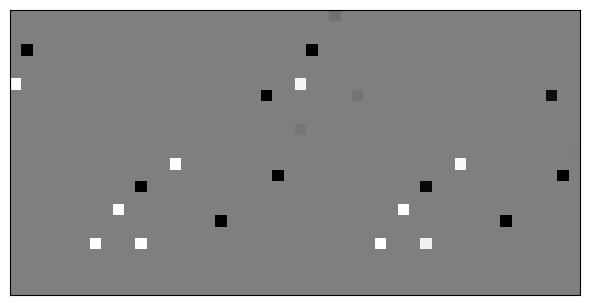

tensor([-0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -3.3974e-04,
         3.5763e-06,  2.1353e-05], grad_fn=<CatBackward0>)

In [ ]:
# Plot the figure
plt.figure(figsize=(6, 4))
yz = torch.cat([y, z])
print(yz.shape)
plt.imshow(yz.detach().view(2*w_s, h_s).T, cmap=plt.cm.gray_r)
plt.xticks([])  # No ticks on x axis
plt.yticks([])  # No ticks on y axis
plt.tight_layout()
plt.grid(False)
plt.show()
yz

In [ ]:

hopfield_model = HopfieldNetworkTorch(T)

def forward_ca3_memory_model(hopfield_model, pp):
    u = hopfield_model(pp)
    return u

def train_ca3_memory_model(hopfield_model, y, z):
    # ca3_input = torch.cat([y, z]).clone().detach()
    # for i in range(5):
    hopfield_model.store_pattern(z)
    # hopfield_model.store_patterns(torch.stack([y, y, y, y]))
    u = forward_ca3_memory_model(hopfield_model, z)
    return u


In [ ]:
z = torch.clamp(z * 10.0, min=-1.0, max=1.0)
for i in range (2):
    u = train_ca3_memory_model(hopfield_model, y, z)

zz = torch.clamp(zz * 10.0, min=-1.0, max=1.0)
for i in range (2):
    uu = train_ca3_memory_model(hopfield_model, yy, zz)

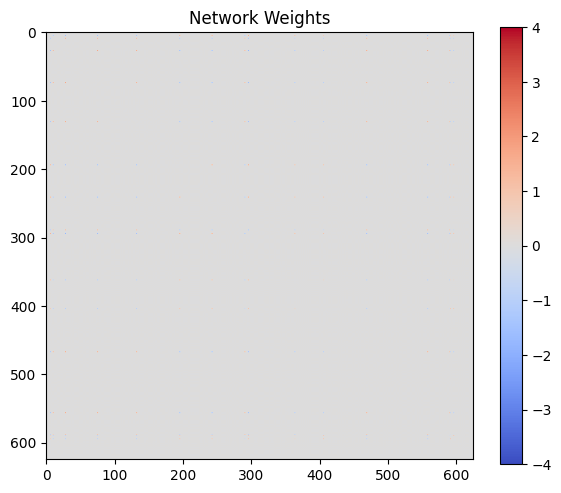

In [ ]:
hopfield_model.plot_weights()

In [ ]:
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, h, d_model, d_context, d_output):
        super(Attention, self).__init__()
        self.h = h
        self.d_k = d_model // h
        self.d_v = d_context
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.out_linear = nn.Linear(d_model, d_output)

    def forward(self, z):
        if len(z.shape) == 1:
            batch_size = 1
        else:
            batch_size = z.shape[0]
        
        zz = z.view(batch_size, self.d_k)
        q = zz[:, :]
        k = zz[:, :]
        v = zz[:, :]
        
        query = self.q_linear(q)
        key = self.k_linear(k)
        value = self.v_linear(v)
        
        key_t = key.transpose(-2, -1)
        scores = torch.matmul(query, key_t) / math.sqrt(self.d_k)
        for x in range(self.d_v):
            for y in range(self.d_v):
                if y < x:
                    scores[:, x, y] = torch.zeros((batch_size))
                    
        p_attn = F.softmax(scores, dim=-1)

        x = torch.matmul(p_attn, value)

        x = self.out_linear(x)
        x = torch.sum(x, 1)
        return x

### Visualization

This is what is really stored in memory. Trying to grasp what kind of transformation happens in these three networks.

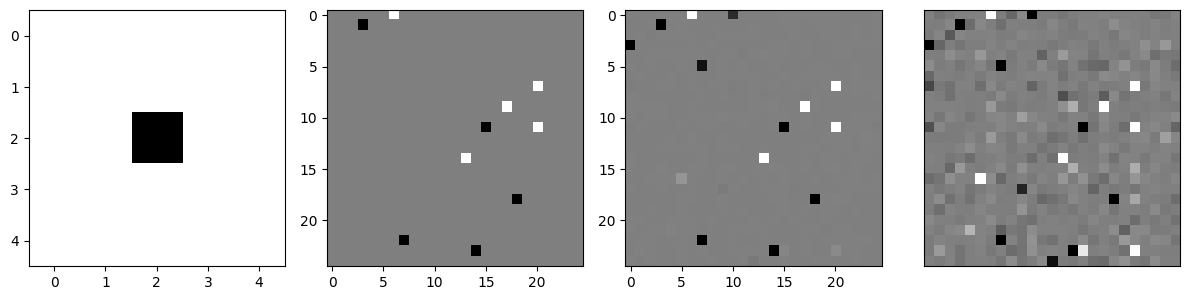

In [ ]:
cmap = plt.cm.gray
norm = plt.Normalize(vmin=-1, vmax=1)

fig, axs = plt.subplots(1, 4, figsize=(12, 4))
axs[0].imshow(x.view(w,h), cmap=plt.cm.gray_r, norm=norm)
axs[1].imshow(y.view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
axs[2].imshow(z.detach().view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
axs[3].imshow(u.view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)

# Plot the figure
#plt.figure(figsize=(6, 4))
#plt.imshow(x, cmap=plt.cm.gray_r, norm=norm)
plt.xticks([])  # No ticks on x axis
plt.yticks([])  # No ticks on y axis
plt.tight_layout()
plt.grid(False)
plt.show()

## Mapping and reconstruction

This is the last block that is mainly used for retrieval. 

The idea is to take the output from the Hopfield network (or memory retrieval) and map it back to the original input space for comparison.

In [ ]:
class MappingModel(nn.Module):
    """
    Goal: pattern mapping
    Methods: compare what stored in memory with the original
    """
    
    def __init__(self, input_size, hidden_size, output_size):
        super(MappingModel, self).__init__()
        
        # Layers for mapping and reconstruction
        self.fc_map = nn.Linear(input_size, hidden_size)  # Map Hopfield output to hidden representation
        self.fc_reconstruct = nn.Linear(hidden_size, output_size)  # Reconstruct to original size

    def forward(self, x):
        """
        Forward pass compares stored Hopfield output with the original input
        """
        # Map the Hopfield output to a hidden representation
        mapping = self.fc_map(x)
        hidden_repr = torch.tanh(mapping)
        reconstructed_input = self.fc_reconstruct(hidden_repr)
        return reconstructed_input

In [ ]:

# Instantiate the model
ca1_model = MappingModel(input_size, hidden_size, output_size)

# Define optimizer (e.g., Adam)
ca1_optimizer = optim.Adam(ca1_model.parameters(), lr=0.0001)

ca1_criterion = nn.MSELoss() # good for comparing pixel values

def forward_ca1_model(ca1_model, u, x):
    ca1_input = torch.cat([u, x]) # u -> K, x -> N
    # Compare reconstruction with the original input
    v = ca1_model(ca1_input)
    return v
    
def train_ca1_model(ca1_model, u, x, a):
    # Zero the parameter gradients
    ca1_optimizer.zero_grad()

    v = forward_ca1_model(ca1_model, u, x)
    loss = ca1_criterion(v, a)

    # Backward pass: compute gradients
    loss.backward()

    # Optimization step: update weights
    ca1_optimizer.step()

    print("Loss:", loss.item())
    print("Reconstructed Input:", v)
    
    return v

Loss: 1.0298089981079102
Reconstructed Input: tensor([ 0.0401, -0.0733, -0.0691, -0.0218,  0.0206, -0.0285,  0.0863, -0.0303,
         0.0774, -0.1543,  0.0690, -0.0978, -0.0805, -0.0116,  0.0484, -0.0096,
        -0.0623, -0.2552,  0.1250,  0.0555,  0.1420, -0.0920,  0.0499, -0.3167,
         0.0581], grad_fn=<AddBackward0>)
Loss: 0.9908738136291504
Reconstructed Input: tensor([ 0.0223, -0.0880, -0.0529, -0.0351,  0.0012, -0.0452,  0.0704, -0.0081,
         0.0632, -0.1754,  0.0880, -0.0754, -0.0609,  0.0095,  0.0708, -0.0399,
        -0.0798, -0.2289,  0.1012,  0.0344,  0.1208, -0.1069,  0.0649, -0.3334,
         0.0377], grad_fn=<AddBackward0>)
Loss: 0.9527255892753601
Reconstructed Input: tensor([ 0.0036, -0.1035, -0.0367, -0.0478, -0.0182, -0.0618,  0.0546,  0.0138,
         0.0488, -0.1962,  0.1070, -0.0527, -0.0416,  0.0304,  0.0932, -0.0702,
        -0.0981, -0.2018,  0.0778,  0.0136,  0.0995, -0.1214,  0.0795, -0.3497,
         0.0177], grad_fn=<AddBackward0>)
Loss: 0.91535085

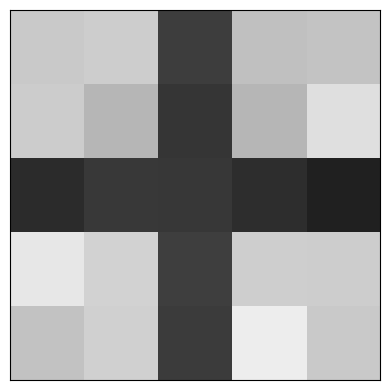

In [ ]:
a = output_1.flatten()
aa = output_2.flatten()

for i in range(30):
    v = train_ca1_model(ca1_model, u, x, a)


# Plot the figure
plt.figure(figsize=(6, 4))
plt.imshow(v.view(w,h).detach(), cmap=plt.cm.gray_r, norm=norm)
plt.xticks([])  # No ticks on x axis
plt.yticks([])  # No ticks on y axis
plt.tight_layout()
plt.grid(False)
plt.show()

In [ ]:

# x = input_2.flatten()
# a = output_2.flatten()

# y = forward_dg_model(dg_model, x)
# z, _ = train_ec_to_ca3_model(ec_model, x, y)
# u = train_ca3_memory_model(hopfield_model, y, z)
# v = train_ca1_model(ca1_model, u, x, a)


In [ ]:
# fig, axs = plt.subplots(1, 5, figsize=(12, 4))
# axs[0].imshow(x.view(w,h), cmap=plt.cm.gray_r, norm=norm)
# axs[1].imshow(y.view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
# axs[2].imshow(z.detach().view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
# axs[3].imshow(u.view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
# axs[4].imshow(v.view(w,h).detach(), cmap=plt.cm.gray_r, norm=norm)

# plt.xticks([])  # No ticks on x axis
# plt.yticks([])  # No ticks on y axis
# plt.tight_layout()
# plt.grid(False)
# plt.show()

Loss: 1.2944787740707397
Reconstructed Input: tensor([-0.4273, -0.4432,  0.3538, -0.3706, -0.3763, -0.4685, -0.2064,  0.4598,
        -0.2629, -0.5680,  0.4758,  0.3146,  0.3890,  0.4246,  0.5032, -0.5867,
        -0.4169,  0.2597, -0.3580, -0.3889, -0.3337, -0.4542,  0.4421, -0.6847,
        -0.4009], grad_fn=<AddBackward0>)
Loss: 1.2981868982315063
Reconstructed Input: tensor([-0.4426, -0.4584,  0.3625, -0.3850, -0.3845, -0.4834, -0.2226,  0.4667,
        -0.2787, -0.5731,  0.4810,  0.3227,  0.3970,  0.4325,  0.5189, -0.6006,
        -0.4313,  0.2692, -0.3755, -0.3981, -0.3426, -0.4610,  0.4558, -0.6874,
        -0.4087], grad_fn=<AddBackward0>)
Loss: 1.2937312126159668
Reconstructed Input: tensor([-0.4577, -0.4740,  0.3665, -0.3997, -0.3884, -0.4988, -0.2396,  0.4677,
        -0.2948, -0.5727,  0.4802,  0.3258,  0.3997,  0.4353,  0.5347, -0.6134,
        -0.4458,  0.2739, -0.3933, -0.4027, -0.3469, -0.4626,  0.4690, -0.6841,
        -0.4112], grad_fn=<AddBackward0>)
Loss: 1.28290557

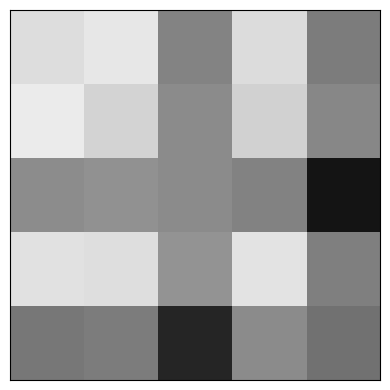

In [ ]:
# Another step
for i in range(30):
    vv = train_ca1_model(ca1_model, uu, xx, aa)


plt.figure(figsize=(6, 4))
plt.imshow(vv.view(w,h).detach(), cmap=plt.cm.gray_r, norm=norm)
plt.xticks([])  # No ticks on x axis
plt.yticks([])  # No ticks on y axis
plt.tight_layout()
plt.grid(False)
plt.show()

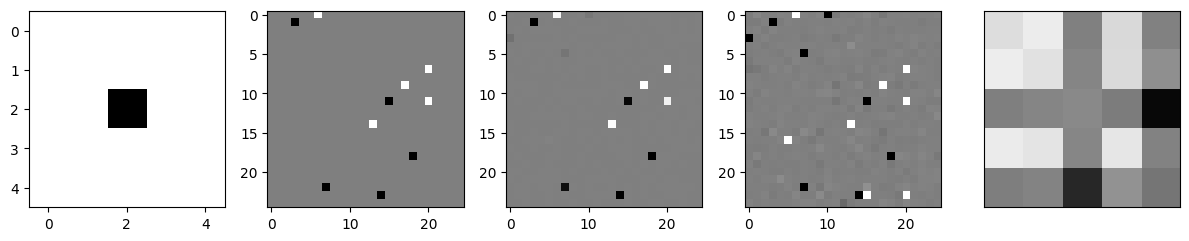

In [ ]:

x = input_1.flatten()
a = output_1.flatten()

with torch.no_grad():
    y = forward_dg_model(dg_model, x)
    z = forward_ec_to_ca3_model(ec_model, x)
    u = forward_ca3_memory_model(hopfield_model, z)
    v = forward_ca1_model(ca1_model, u, x)

    fig, axs = plt.subplots(1, 5, figsize=(12, 4))
    axs[0].imshow(x.view(w,h), cmap=plt.cm.gray_r, norm=norm)
    axs[1].imshow(y.view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
    axs[2].imshow(z.detach().view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
    axs[3].imshow(u.view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
    axs[4].imshow(v.view(w,h).detach(), cmap=plt.cm.gray_r, norm=norm)

plt.xticks([])  # No ticks on x axis
plt.yticks([])  # No ticks on y axis
plt.tight_layout()
plt.grid(False)
plt.show()

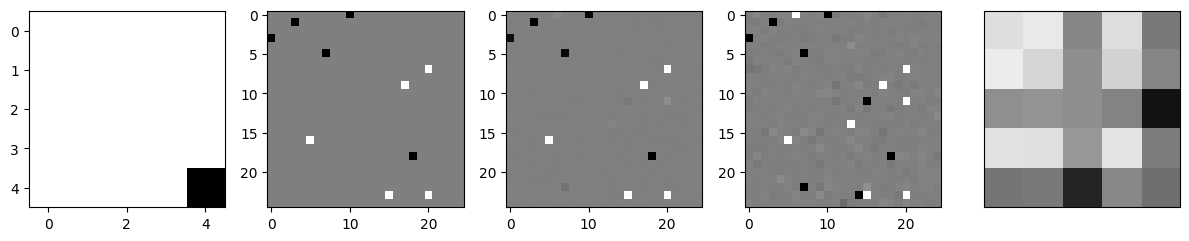

In [ ]:
x = input_2.flatten()
a = output_2.flatten()

with torch.no_grad():
    y = forward_dg_model(dg_model, x)
    z = forward_ec_to_ca3_model(ec_model, x)
    u = forward_ca3_memory_model(hopfield_model, z)
    v = forward_ca1_model(ca1_model, u, x)

    fig, axs = plt.subplots(1, 5, figsize=(12, 4))
    axs[0].imshow(x.view(w,h), cmap=plt.cm.gray_r, norm=norm)
    axs[1].imshow(y.view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
    axs[2].imshow(z.detach().view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
    axs[3].imshow(u.view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
    axs[4].imshow(v.view(w,h).detach(), cmap=plt.cm.gray_r, norm=norm)

plt.xticks([])  # No ticks on x axis
plt.yticks([])  # No ticks on y axis
plt.tight_layout()
plt.grid(False)
plt.show()

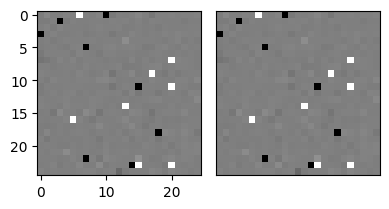

In [ ]:

with torch.no_grad():
    x1 = input_1.flatten()
    a1 = output_1.flatten()

    y1 = forward_dg_model(dg_model, x1)
    z1 = forward_ec_to_ca3_model(ec_model, x1)
    u1 = forward_ca3_memory_model(hopfield_model, z1)

    x2 = input_2.flatten()
    a2 = output_2.flatten()

    y2 = forward_dg_model(dg_model, x2)
    z2 = forward_ec_to_ca3_model(ec_model, x2)
    u2 = forward_ca3_memory_model(hopfield_model, z2)


    fig, axs = plt.subplots(1, 2, figsize=(4, 4))
    axs[0].imshow(u1.view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)
    axs[1].imshow(u2.view(w_s, h_s), cmap=plt.cm.gray_r, norm=norm)


plt.xticks([])  # No ticks on x axis
plt.yticks([])  # No ticks on y axis
plt.tight_layout()
plt.grid(False)
plt.show()

C:\Users\neupo\AppData\Local\Temp\ipykernel_15924\3567843866.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y1_vs_y2 = torch.tensor((y1+1.0)/2.0 - (y2+1.0)/2.0)


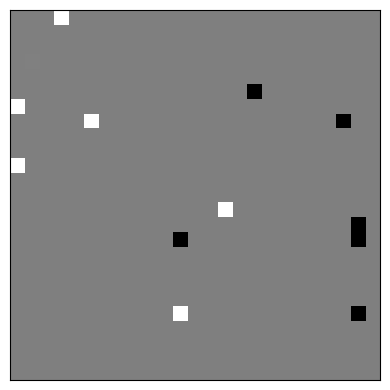

tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00, -4.9919e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        -4.9834e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00, -1.3626e-04,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0

In [ ]:
# Plot the figure
plt.figure(figsize=(6, 4))
y1_vs_y2 = torch.tensor((y1+1.0)/2.0 - (y2+1.0)/2.0)
plt.imshow(y1_vs_y2.detach().view(w_s, h_s).T, cmap=plt.cm.gray_r)
plt.xticks([])  # No ticks on x axis
plt.yticks([])  # No ticks on y axis
plt.tight_layout()
plt.grid(False)
plt.show()
y1_vs_y2

In [ ]:
# ( 1 ) * (1 0) = [ 1 0
#   0               0 0 ]
# a = torch.tensor([1,-1]).unsqueeze(1)
# # tensor([[ 1, -1],
#         #[-1,  1]])
# w1 = torch.mm(a, a.T)

In [ ]:
# b = torch.tensor([1,1]).unsqueeze(1)
# w2 = torch.mm(b, b.T)
# tensor([[ 1, -1],
        #[-1,  1]])

In [ ]:
# torch.tanh(torch.mm(w1+w2, a))

In [ ]:
hopfield_model.weights

tensor([[ 0.0000e+00, -1.6279e-05, -4.2125e-06,  ...,  1.1709e-05,
          1.7132e-06, -7.0783e-07],
        [-1.6279e-05,  0.0000e+00,  1.9598e-05,  ..., -5.3397e-05,
         -6.5744e-06,  3.2468e-06],
        [-4.2125e-06,  1.9598e-05,  0.0000e+00,  ..., -1.5921e-05,
         -1.3431e-06,  9.7752e-07],
        ...,
        [ 1.1709e-05, -5.3397e-05, -1.5921e-05,  ...,  0.0000e+00,
          4.0524e-06, -2.5949e-06],
        [ 1.7132e-06, -6.5744e-06, -1.3431e-06,  ...,  4.0524e-06,
          0.0000e+00, -2.3938e-07],
        [-7.0783e-07,  3.2468e-06,  9.7752e-07,  ..., -2.5949e-06,
         -2.3938e-07,  0.0000e+00]], grad_fn=<CopySlices>)

In [ ]:
t, _ = torch.topk(torch.tanh(torch.mm(hopfield_model.weights, z1.unsqueeze(1))).flatten(), 15)
t

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.3656,
        0.1474, 0.1464, 0.1003, 0.0965, 0.0757, 0.0742],
       grad_fn=<TopkBackward0>)

In [ ]:
w = torch.zeros(w_s, h_s)

In [ ]:
w = torch.mm(z.unsqueeze(1), z.unsqueeze(1).T)

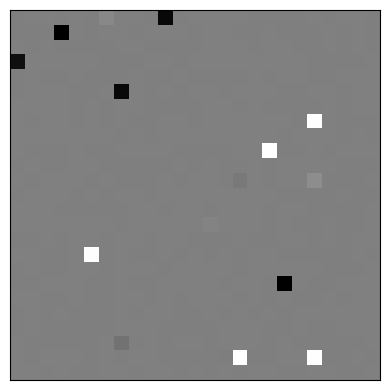

In [ ]:
s = torch.rand(625).unsqueeze(1)
for i in range(1):
    s = torch.mm(w, s)

plt.figure(figsize=(6, 4))
plt.imshow(z2.view(w_s, h_s).detach(), cmap=plt.cm.gray_r, norm=norm)
plt.xticks([])  # No ticks on x axis
plt.yticks([])  # No ticks on y axis
plt.tight_layout()
plt.grid(False)
plt.show()

In [ ]:
w_s * h_s

625